In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [37]:
%matplotlib inline
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
import os
data_folder = os.path.join(os.curdir,'img')
data_set = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file))]

In [39]:
data_set

['.\\img\\img1.jpg',
 '.\\img\\img10.jpg',
 '.\\img\\img11.jpg',
 '.\\img\\img12.jpg',
 '.\\img\\img13.jpg',
 '.\\img\\img14.jpg',
 '.\\img\\img15.jpg',
 '.\\img\\img16.jpg',
 '.\\img\\img17.jpg',
 '.\\img\\img18.jpg',
 '.\\img\\img19.jpg',
 '.\\img\\img2.jpg',
 '.\\img\\img20.jpg',
 '.\\img\\img21.jpg',
 '.\\img\\img22.jpg',
 '.\\img\\img23.jpg',
 '.\\img\\img24.jpg',
 '.\\img\\img25.jpg',
 '.\\img\\img26.jpg',
 '.\\img\\img27.jpg',
 '.\\img\\img28.jpg',
 '.\\img\\img29.jpg',
 '.\\img\\img3.jpg',
 '.\\img\\img30.jpg',
 '.\\img\\img31.jpg',
 '.\\img\\img32.jpg',
 '.\\img\\img33.jpg',
 '.\\img\\img34.jpg',
 '.\\img\\img35.jpg',
 '.\\img\\img36.jpg',
 '.\\img\\img37.jpg',
 '.\\img\\img38.jpg',
 '.\\img\\img39.jpg',
 '.\\img\\img4.jpg',
 '.\\img\\img40.jpg',
 '.\\img\\img41.jpg',
 '.\\img\\img42.jpg',
 '.\\img\\img43.jpg',
 '.\\img\\img44.jpg',
 '.\\img\\img45.jpg',
 '.\\img\\img46.jpg',
 '.\\img\\img47.jpg',
 '.\\img\\img48.jpg',
 '.\\img\\img49.jpg',
 '.\\img\\img5.jpg',
 '.\\img\\img50

In [119]:
def detect_match(algorithm,query_img,train_img,min_match_count,verbose=False):
    query_image = query_img
    train_image = train_img
    key_pts1,des1 = algorithm(query_image,None)
    key_pts2,des2 = algorithm(train_image,None)
    msed=np.inf
    if not (isinstance(des1,np.float32)&isinstance(des2,np.float32)):
        des1 = np.float32(des1)
        des2 = np.float32(des2)
    
    flann_idx = 1
    index_params = dict(algorithm = flann_idx, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = [m for m,n in matches if m.distance < 0.7*n.distance]
    
    if len(good)>min_match_count:
        src_pts = np.float32([ key_pts1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ key_pts2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        if M is None:
            return [0],[0],[0],[0],np.inf
        #print(M,mask)
        matchesMask = mask.ravel().tolist()
        h,w = query_image.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        msed = np.mean([np.sqrt(np.sum(diff)) for diff in (np.power(pts-dst,2))]/(np.sqrt(h**2+w**2)))
        #cv2.polylines(train_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        if verbose==True:
            print( "Not enough matches are found - {}/{}".format(len(good), min_match_count) )
        matchesMask = [0]
    
    return key_pts1, key_pts2, good, matchesMask, msed

def plot_match(query_img, train_img, key_pts1, key_pts2, good, matchesMask):
    draw_params = dict(matchColor = (255.0,255.0,255.0), # draw matches in white color
                   singlePointColor = (255.0,0,0),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img3 = cv2.drawMatches(query_img, key_pts1, train_img, key_pts2, good, None, **draw_params)
    plt.imshow(img3, 'gray'),plt.show()

In [105]:
alg_dict=dict(sift=cv2.xfeatures2d.SIFT_create().detectAndCompute,
              surf=cv2.xfeatures2d.SURF_create(200).detectAndCompute,
              akaze=cv2.AKAZE_create().detectAndCompute)
min_matches=10

In [42]:
images = [cv2.imread(image,0) for image in data_set]

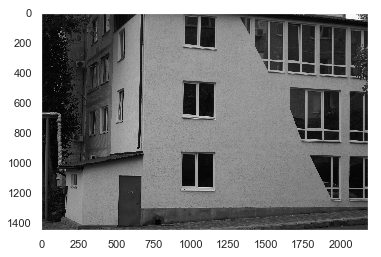

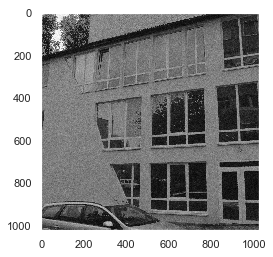

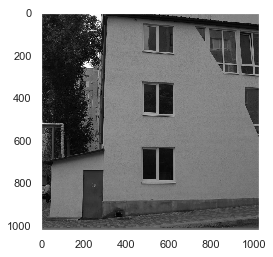

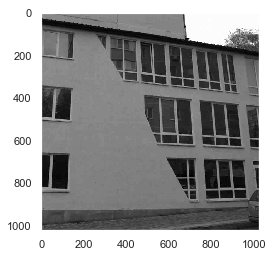

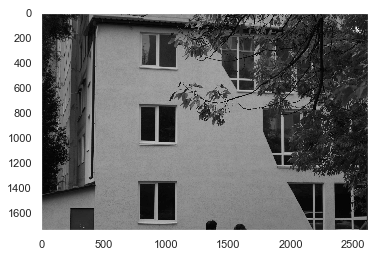

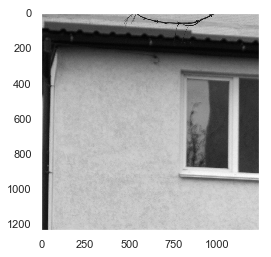

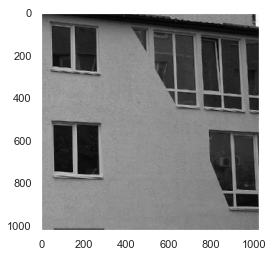

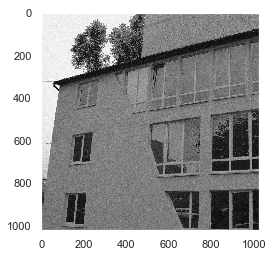

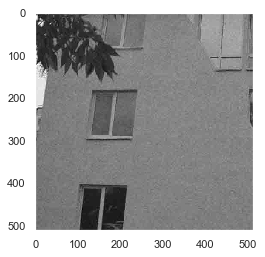

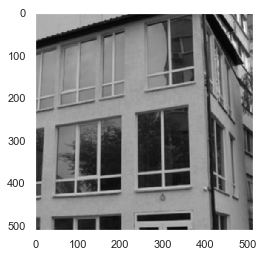

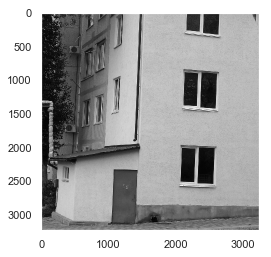

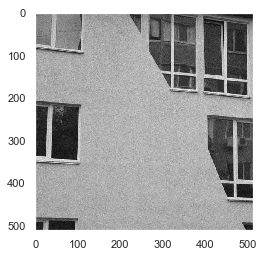

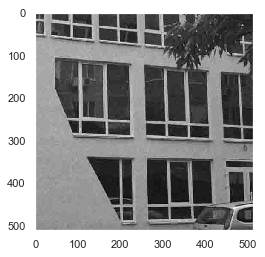

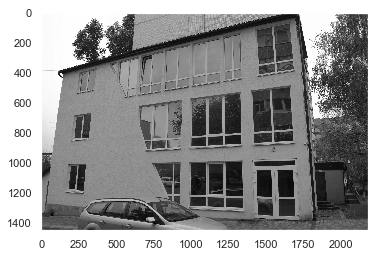

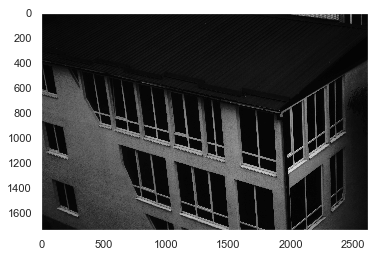

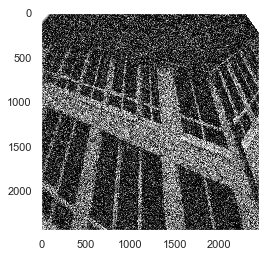

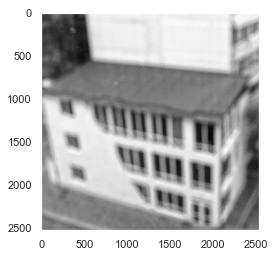

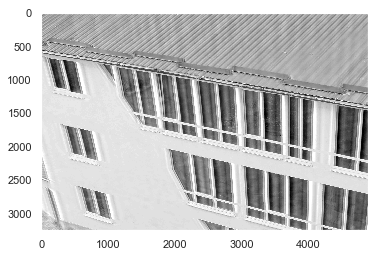

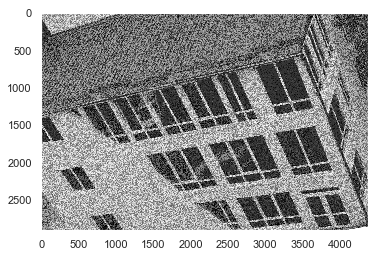

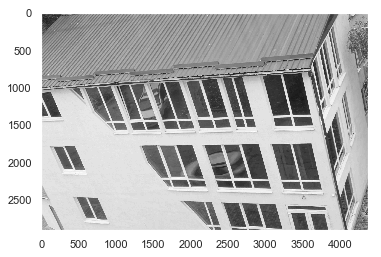

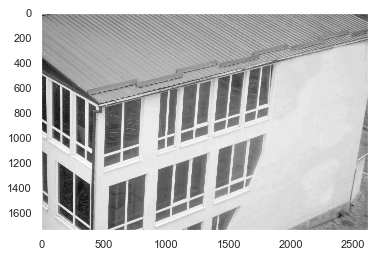

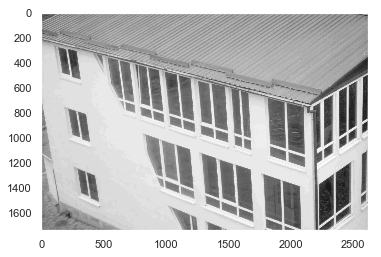

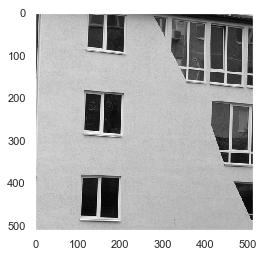

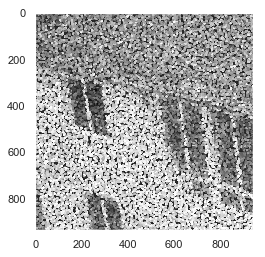

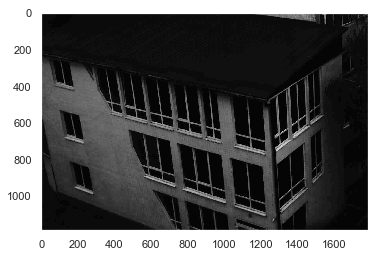

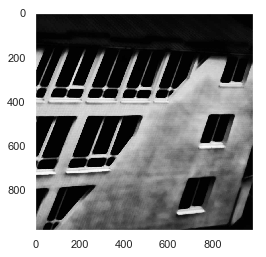

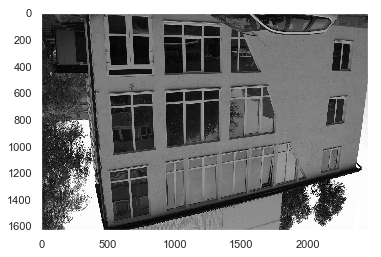

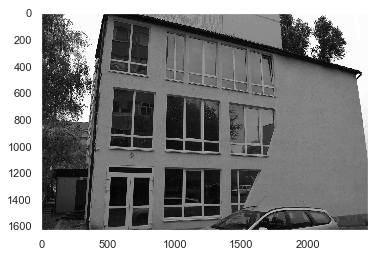

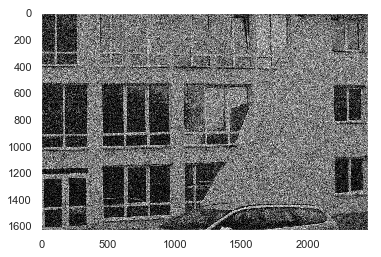

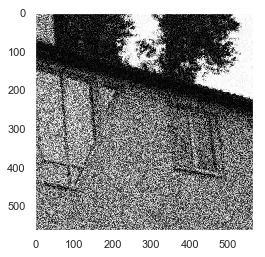

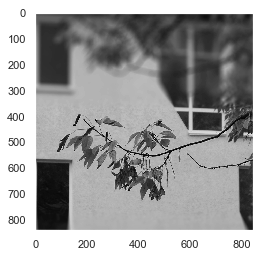

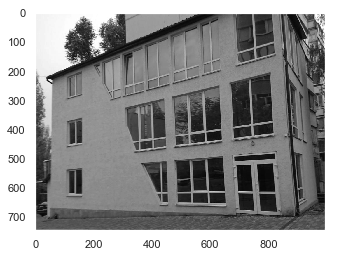

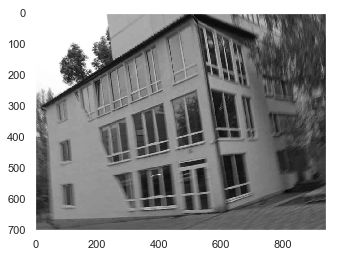

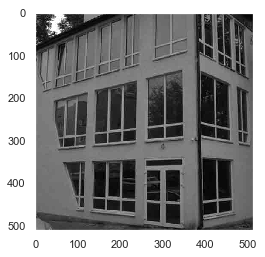

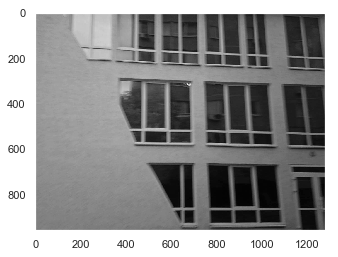

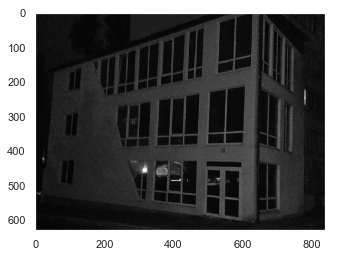

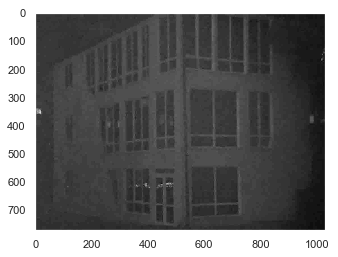

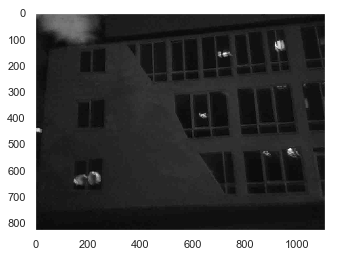

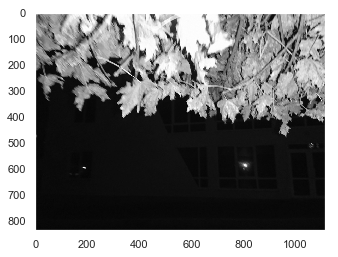

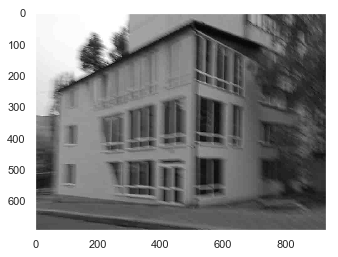

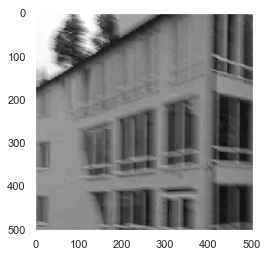

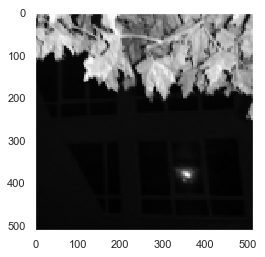

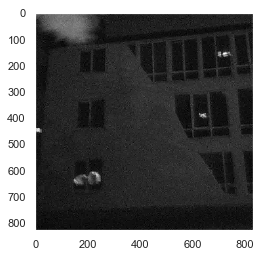

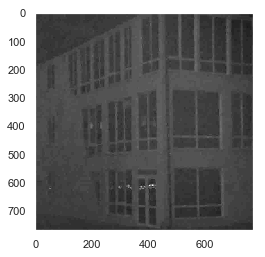

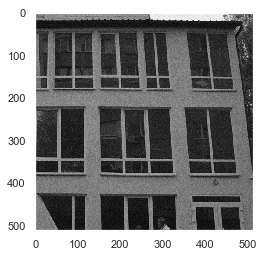

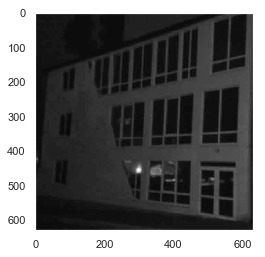

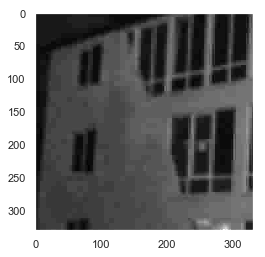

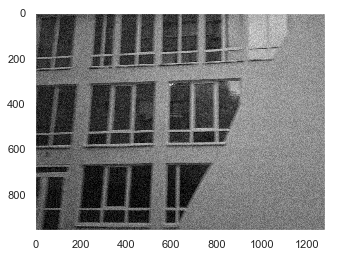

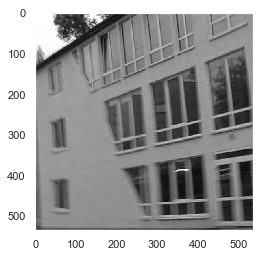

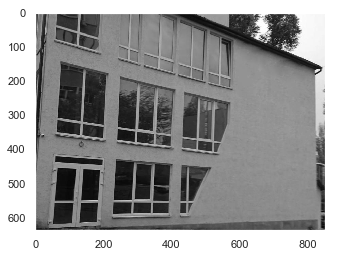

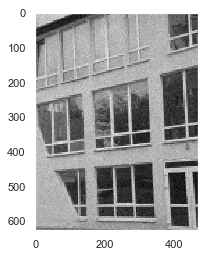

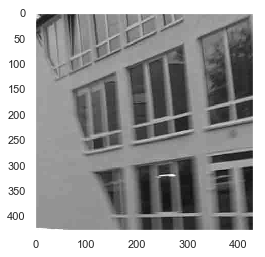

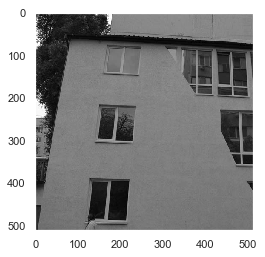

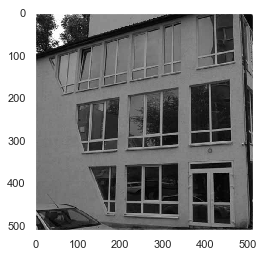

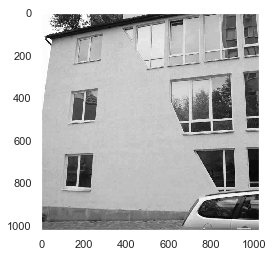

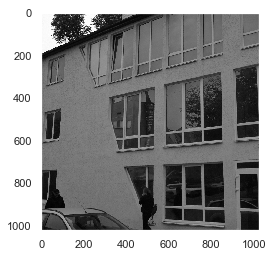

<Figure size 432x288 with 0 Axes>

In [43]:
sns.set()
with sns.axes_style({'axes.grid': False}):
    for idx, image in enumerate(images): 
        plt.imshow(images[idx], 'gray'),plt.show()
        plt.figure(idx+1)

In [158]:
key_pts1, key_pts2, good, matchesMask,msed = detect_match(algorithm=alg_dict['sift'],query_img=images[9],train_img=images[13],
                                                     min_match_count=10)
msed

1.7270938

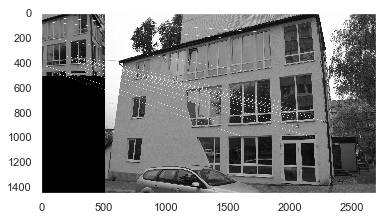

In [159]:
sns.set()
with sns.axes_style({'axes.grid': False}):
    img3=plot_match(query_img=images[9], key_pts1=key_pts1,train_img=images[13],  key_pts2=key_pts2, good=good, matchesMask=matchesMask)
    plt.show(img3)

In [148]:
import itertools
import time
inliers_matches = dict()
indexes = list(itertools.product(alg_dict.keys(),["inliers/matches","distance MSE","time (ms)"]))
for im_j_idx in range(len(images)):
    inliers_matches["img"+str(im_j_idx)]=list()

In [149]:
for alg_name, alg in alg_dict.items():
    for im_i_idx, image_i in enumerate(images):
        #print("Comparing img{0} and img{1}".format(im_i_idx,im_j_idx))
        time_start=time.monotonic_ns()
        _, __, match, inlier ,msd = detect_match(algorithm=alg,query_img=image_i,train_img=images[15],
                                                     min_match_count=5)
        time_end=time.monotonic_ns()
        if match==0:
            match=np.inf
        inliers_matches["img"+str(im_i_idx)].append(np.sum(inlier)/(len(match)))
        inliers_matches["img"+str(im_i_idx)].append(msd)
        inliers_matches["img"+str(im_i_idx)].append((time_end-time_start)/1e6)

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [154]:
import pandas as pd
index = pd.MultiIndex.from_tuples(indexes,names=['algorithm','property'])
comparison_df=pd.DataFrame(inliers_matches,index=index)

In [155]:
comparison_df

img0         img1         img2         img3  \
algorithm property                                                              
sift      inliers/matches     0.225000     0.150000     0.400000     0.238095   
          distance MSE        0.508150     0.723929     1.263756     0.545805   
          time (ms)        3125.000000  2844.000000  2547.000000  2547.000000   
surf      inliers/matches     0.193548     0.228571     0.357143     0.200000   
          distance MSE        0.476415     0.887595     0.579624     0.735257   
          time (ms)        5734.000000  5719.000000  5453.000000  5437.000000   
akaze     inliers/matches     0.000000     0.666667     0.000000     0.333333   
          distance MSE             inf     0.614839          inf     0.516552   
          time (ms)        1843.000000  1500.000000  1453.000000  1391.000000   

                                  img4         img5         img6         img7  \
algorithm property                                                              
sift      inliers/matches     0.200000     0.000000     0.000000     0.230769   
          distance MSE        0.514012          inf          inf     0.796522   
          time (ms)        3484.000000  2485.000000  2375.000000  2656.000000   
surf      inliers/matches     0.193548     0.000000     0.000000     0.218750   
          distance MSE        0.626074          inf          inf     0.745895   
          time (ms)        6704.000000  5250.000000  5093.000000  5610.000000   
akaze     inliers/matches     0.333333          NaN     0.000000     0.000000   
          distance MSE        0.541777          inf          inf          inf   
          time (ms)        2219.000000  1500.000000  1453.000000  1484.000000   

                                  img8         img9     ...             img46  \
algorithm property                                      ...                     
sift      inliers/matches     0.000000     0.666667     ...               NaN   
          distance MSE             inf     1.144009     ...               inf   
          time (ms)        2234.000000  2266.000000     ...       2188.000000   
surf      inliers/matches     0.000000     0.000000     ...               NaN   
          distance MSE             inf          inf     ...               inf   
          time (ms)        5203.000000  5015.000000     ...       5063.000000   
akaze     inliers/matches          NaN          NaN     ...               NaN   
          distance MSE             inf          inf     ...               inf   
          time (ms)        1297.000000  1391.000000     ...       1266.000000   

                                 img47        img48        img49        img50  \
algorithm property                                                              
sift      inliers/matches     0.192308     0.444444     0.294118     0.333333   
          distance MSE        0.604315     3.966247     0.619134     0.920207   
          time (ms)        2546.000000  2375.000000  2360.000000  2469.000000   
surf      inliers/matches     0.242857     0.454545     0.413793     0.500000   
          distance MSE        0.594535     1.714670     1.020298     3.650269   
          time (ms)        5594.000000  5015.000000  5328.000000  5078.000000   
akaze     inliers/matches     0.000000     0.000000     0.000000     0.000000   
          distance MSE             inf          inf          inf          inf   
          time (ms)        1484.000000  1313.000000  1375.000000  1313.000000   

                                 img51        img52        img53        img54  \
algorithm property                                                              
sift      inliers/matches     0.000000     0.500000     0.315789     0.196078   
          distance MSE             inf    37.427437     1.086914     0.699454   
          time (ms)        2234.000000  2250.000000  2297.000000  2578.000000   
surf      inliers/matches     0.571429     0.571429     0.333